# Table of Content
* [Goal](#Goal)
* [Wrangle](#Wrangle)
* [Explore Data Analysis](#Explore)
  * [Overall Top 20](#Over-All-Top-20-Words)
  * [Each Langauge's Top 10 Words](#Top-10-Words-from-Javascript-and-Python)
* [Modeling](#Modeling)
    * [Train](#Train)
    * [Validate](#Validate)
    * [Test](#Test)
* [Conclusion](#Conclusion)

In [1]:
# establishing environment
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from prepare import prep_gitMDs
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

print('Initalized')

Initalized


# Goal
The goal of this project is to use Natural Language Processing (NLP) to predict the primary coding language of a git repo using the repo's README.  

We will also deliver the following:

  * A Jupyter notebook containing detailing to every step of this project
  * A 5-minute presentation about the project, including slides

# Wrangle
We will use the modules ***[prepare.py](https://github.com/NLP-MVPs/nlp-project/blob/main/prepare.py)*** to gather the data, clean the data, and put it into a dataframe. From there we will begin to wrangle the data for exploration focusining mainly on creating word strings and additional dataframe from our data.

[Table of Content](#Table-of-Content)

In [2]:
help(prep_gitMDs)

Help on function prep_gitMDs in module prepare:

prep_gitMDs()
    Uses the helper functions contained within the prepare.py module on the gitMDs repo url list from the acquire.py module to create a unified data frame for exploration
    * Applies a basic_body_clean, tokenizizatize, removestop_words, AND lemmatizes fuctions to the readme body text
      and returns the output as df['clean'].
    * Applies the basic_code_clean, tokenizizatize, and removestop_words fuctions to the top_code 
      and returns it as df['top_code_cleaned]
    * Splits df['top_code_cleaned] into two columns df['top_code_cleaned'] and df['top_percentage_cleaned']
    * Returns the gitMDs as a data frame



### Acquire the data using function from wrangle.py file

In [3]:
# Use the prep_gitMDs fuction to run the acquire and prepare scripts
df = prep_gitMDs()

df.head()

,body,top_code,clean,top_code_clean,percentage
0,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,\n\nJavaScript\n91.3%\n,freecodecamporg ' opensource codebase curricul...,javascript,91.3
1,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,\n\nJavaScript\n97.7%\n,supporting vuejs vuejs mitlicensed open source...,javascript,97.7
2,React · \nReact is a JavaScript library for...,\n\nJavaScript\n95.0%\n,react react javascript library building user i...,javascript,95.0
3,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",\n\nJavaScript\n46.7%\n,bootstrap sleek intuitive powerful frontend fr...,javascript,46.7
4,Airbnb JavaScript Style Guide() {\nA mostly re...,\n\nJavaScript\n100.0%\n,airbnb javascript style guide mostly reasonabl...,javascript,100.0


### Pruning columns and splitting into Train, Validate and Test samples

In [4]:
# dropping columns we won't be using
df.drop(columns = ['body', 'top_code', 'percentage'], inplace = True)

# renaming columns
df.columns = ['readme', 'language']

# splitting data in train, validate and test
train_validate, test = train_test_split(df[['language', 'readme']], 
                                        stratify=df.language, 
                                        test_size=.2, 
                                        random_state=333)

train, validate = train_test_split(train_validate, 
                                   stratify=train_validate.language, 
                                   test_size=.25,
                                   random_state=333)

In [5]:
# printing rows/columns for each dataset to confirm they split correctly
print(train.shape, validate.shape, test.shape)

(137, 2) (46, 2) (46, 2)


### Combining the readme text of each language into separate series' for later exploration

In [6]:
# create series objects for each top_code_clean that is a string of words joined on spaces 
# to make it 1 continious string for python
python_words = ' '.join(train[train.language=='python'].readme)

# for javascript
javascript_words = ' '.join(train[train.language == 'javascript'].readme)

# both python and java script
all_words = ' '.join(train.readme)

In [7]:
# Then for each series remove any stand-alone characters to reduce noise
python_words = re.sub(r'\s.\s', '', python_words)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore

Now that the data has been processed into more usable forms we can begin to explore the data for features we can use in building our models. We will create a wordcloud and frequency chat from the top 20 words used across both programing lanauges, and then we will create a frequency chart and word cloud charts from our top10 words data frame.

[Table of Content](#Table-of-Content)

### Finding the most common words within all READMEs as well as each language's respective READMEs

In [8]:
# For each top_code_clean find out how many times each word happens and put that into a topic_freq obj.
all_freq = pd.Series(all_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()

python_freq.head()

yes        680
unknown    523
no         462
github     339
use        253
dtype: int64

In [9]:
# Combine all the series together into a single data frame to see the word count across all topics
word_counts = (pd.concat([all_freq, python_freq, javascript_freq], axis=1, sort=True)
               .set_axis(['all', 'python', 'javascript', ], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,all,python,javascript
&#9;,566,144,422
&#9;&#9;p,1,1,0
&#9;110,1,0,1
&#9;111,1,0,1
&#9;112,1,0,1


### Create a list of words that combines the top 10 words used by javascript and python into a single list, and then create a top10 dataframe that only looks at those words.

In [10]:
# Top 10 words used by javascript
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)

# top 10 words by python
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)

# combines the lists together
top_10_each = (list(top_10_py_words.index) + list(top_10_js_words.index))

# Create the new data frame where the index values match the top_10_each value
top10 = word_counts[word_counts.index.isin(top_10_each)]

top10

,all,python,javascript
&#9;,566,144,422
apikey,248,248,0
app,373,22,351
application,284,27,257
component,300,14,286
data,405,232,173
file,438,131,307
github,418,339,79
image,378,251,127
install,404,251,153


## Overall Top 20 Words

[Table of Content](#Table-of-Content)

In [11]:
# Create a top 20 all_words df
top_20_all_words = word_counts['all'].sort_values(ascending=False).head(20)

top_20_all_words

native        882
react         879
yes           684
use           588
&#9;          566
javascript    548
no            544
unknown       523
using         438
file          438
github        418
code          413
data          405
install       404
image         378
app           373
example       365
not           334
support       334
api           327
Name: all, dtype: int64

### Word Cloud of top 20 words in all READMEs

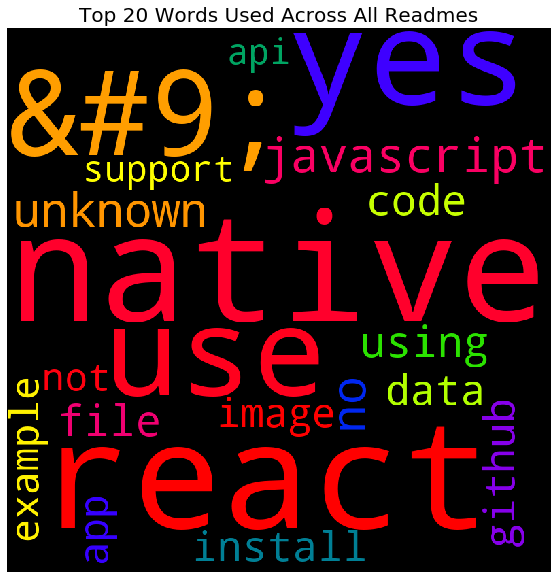

In [12]:
# Turn the dataframes into dictionaries
allz = {k: v for k, v in top_20_all_words.to_dict().items()}

# Use the dictionary objects and .generate_from_frequencies method of WordCloud 
# to generate a wordcloud map for each language
all_top_20_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(allz)

plt.figure(figsize=(10,10))
plt.title("Top 20 Words Used Across All Readmes", fontsize=20)
plt.imshow(all_top_20_cloud)
plt.axis('off')
plt.show()

### Visualization of top 20 words in all READMEs

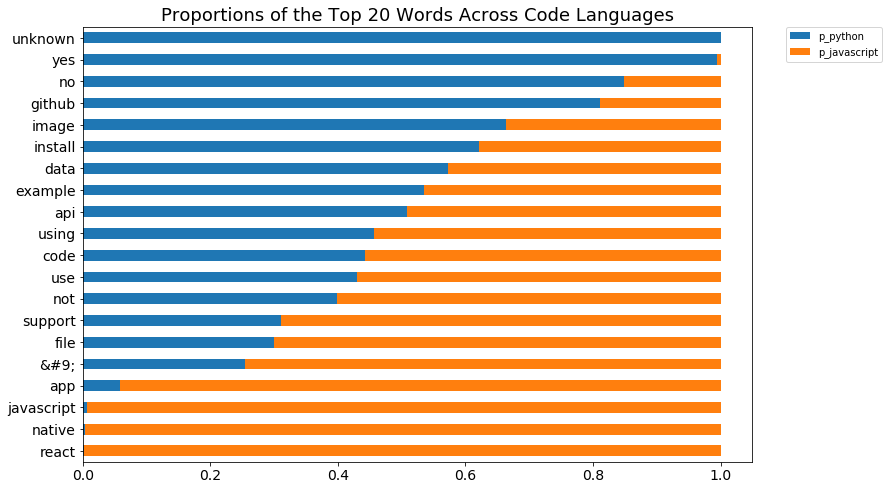

In [13]:
# visualize the percentage each coding language makes up for the top 20 words
(word_counts.assign(p_python = word_counts.python/word_counts['all'], 
                   p_javascript = word_counts.javascript/word_counts['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)
plt.title("Proportions of the Top 20 Words Across Code Languages", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1),borderaxespad=0)
plt.show()

## Top 10 Words from Javascript and Python

[Table of Content](#Table-of-Content)

### Word Cloud of top 10 words in Javascript and Python READMEs

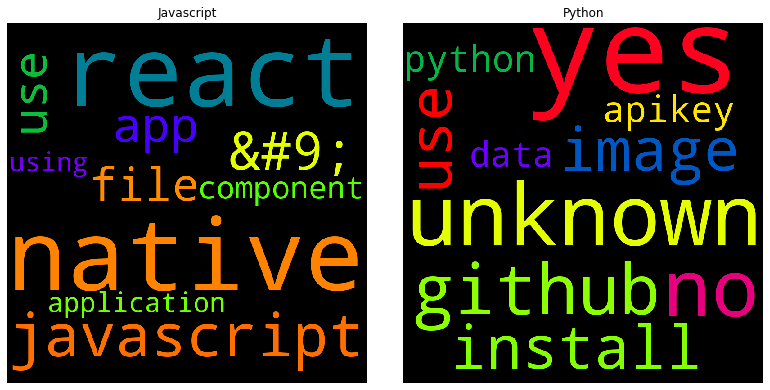

In [14]:
# Createa a top 10 words for each javascript and python
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)

# Turn the dataframes into dictionaries
js = {k: v for k, v in top_10_js_words.to_dict().items()}
py = {k: v for k, v in top_10_py_words.to_dict().items()}


# Use the dictionary objects and .generate_from_frequencies method of WordCloud to generate a wordcloud map for each language
js10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(js)

py10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(py)

# Change the figure size
plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(js10_cloud)
axs[1].imshow(py10_cloud)

axs[0].set_title('Javascript')
axs[1].set_title('Python')

# Turn off the axis
for ax in axs: ax.axis('off')

### Word Cloud of top 10 words in Javascript and Python READMEs

<Figure size 1440x1008 with 0 Axes>

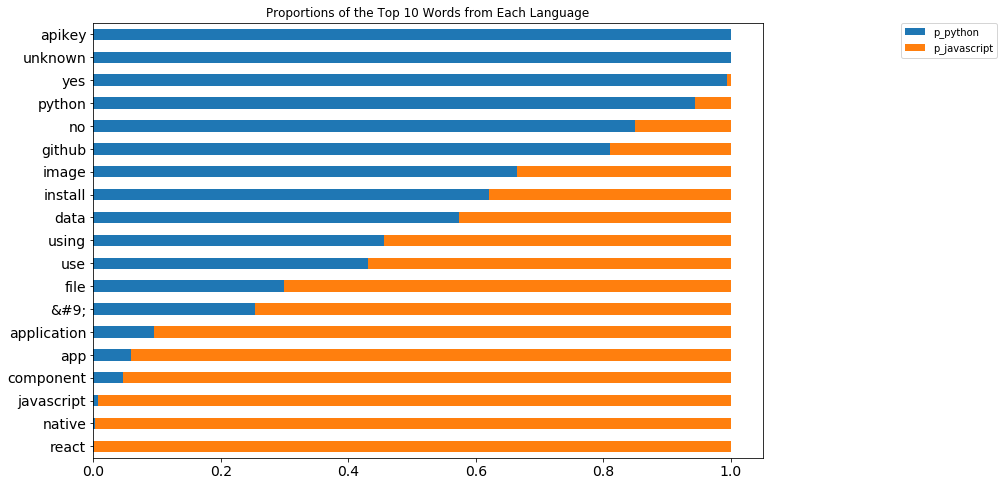

In [15]:
# visualize the percentage each coding language makes up for the top 10words of each programing language
plt.figure(figsize=(20,14))
(top10.assign(p_python = top10.python/top10['all'], 
                   p_javascript = top10.javascript/top10['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)

plt.title("Proportions of the Top 10 Words from Each Language")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)
plt.show()

# Hypothesis Testing
We'll now perform several hypothesis tests to confirm if the presence of certain words within a README are correlated with its respective language.

## Creating column reflecting if README contains word from top 5 JavaScript words 

In [16]:
# creating list of top 5 most common words in JavaScript readmes
top_5_js_words = word_counts['javascript'].sort_values(ascending=False).head(5).index.tolist()

top_5_js_words

['native', 'react', 'javascript', '&#9;', 'app']

In [17]:
# adding column that holds true if a readme contains a "top 5 most common JS word"
# and false otherwise
contains = [train['readme'].str.contains(w) for w in top_5_js_words]

t5_js_index = train[np.any(contains, axis = 0)].index.tolist()

train['has_top_5_js_word'] = train.index.isin(t5_js_index)

train.head()

,language,readme,has_top_5_js_word
74,javascript,leaflet leading opensource javascript library ...,True
193,python,stylegan official tensorflow implementation pi...,True
210,python,beet beet medium library management system obs...,False
152,python,ai learning github page httpsailearningapachec...,False
73,javascript,clipboardjs modern copy clipboard no flash 3kb...,True


## Creating column reflecting if README contains word from top 5 Python words 

In [18]:
# creating list of top 5 most common words in Python readmes
top_5_py_words = word_counts['python'].sort_values(ascending=False).head(5).index.tolist()

top_5_py_words

['yes', 'unknown', 'no', 'github', 'use']

In [19]:
# adding column that holds true if a readme contains a "top 5 most common python word"
# and false otherwise
contains = [train['readme'].str.contains(w) for w in top_5_py_words]

t5_py_index = train[np.any(contains, axis = 0)].index.tolist()

train['has_top_5_py_word'] = train.index.isin(t5_js_index)

train.head()

,language,readme,has_top_5_js_word,has_top_5_py_word
74,javascript,leaflet leading opensource javascript library ...,True,True
193,python,stylegan official tensorflow implementation pi...,True,True
210,python,beet beet medium library management system obs...,False,False
152,python,ai learning github page httpsailearningapachec...,False,False
73,javascript,clipboardjs modern copy clipboard no flash 3kb...,True,True


### has_react and has_apikey categorical columns
In addition to looking at the top 5 words from each coding language, we will create has_react and has_apikey features. These two words were choosen because react was only found to be in JavaScript labled readmes while apikey was only in python labled readmes and both were in the top of most seen words for each's language.

In [20]:
# adding has_react and has_react columns that hold true if a readme contains has_react and false otherwise
train['has_react'] = train.readme.str.contains('react')

# adding has_react and has_apikey columns that hold true if a readme contains has_react and false otherwise
train['has_apikey'] = train.readme.str.contains('apikey')

train.head()

,language,readme,has_top_5_js_word,has_top_5_py_word,has_react,has_apikey
74,javascript,leaflet leading opensource javascript library ...,True,True,False,False
193,python,stylegan official tensorflow implementation pi...,True,True,False,False
210,python,beet beet medium library management system obs...,False,False,False,False
152,python,ai learning github page httpsailearningapachec...,False,False,False,False
73,javascript,clipboardjs modern copy clipboard no flash 3kb...,True,True,False,False


## Hypothsis Testing

Now that we've created 4 features based on our visual observations we should test and see if these observations are statisitically signficant before adding them to our models. 

As we are comparing two catagorical variable we will need to conduct a Chi-Squared test for each of our created features against _language_. From the testing below, we see that has_react does have a statisitically significant realtionship with language. 

### Test 1

H0: The presence of a "top 5 most common JavaScript" word and a repo's programming language are indepedent<br>
Ha: The presence of a "top 5 most common JavaScript" word and a repo's programming language are depedent

In [21]:
# Conduct a Chi Squared test against has_top_5_js_word
observed = pd.crosstab(train.language, train.has_top_5_js_word)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('alpha = .05\n')
print(f'has_top_5_js_word values\nchi2: {chi2}, p: {p}\n')

alpha = .05

has_top_5_js_word values
chi2: 3.427463745335704, p: 0.06412050161183944



### Test 2

H0: The presence of a "top 5 most common Python" word and a repo's programming language are indepedent<br>
Ha: The presence of a "top 5 most common Python" word and a repo's programming language are depedent

In [22]:
# Conduct a Chi Squared test against has_top_5_js_word
observed = pd.crosstab(train.language, train.has_top_5_py_word)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('alpha = .05\n')
print(f'has_top_5_py_word values \nchi2: {chi2}, p: {p}\n')

alpha = .05

has_top_5_py_word values 
chi2: 3.427463745335704, p: 0.06412050161183944



### Test 3

H0: The presence of the text, "has_react", in a readme, and a repo's programming language are indepedent<br>
Ha: The presence of the text, "has_react", in a readme, and a repo's programming language are depedent

In [23]:
# Conduct a Chi Squared test against has_react
observed = pd.crosstab(train.language, train.has_react)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('alpha = .05\n')
print(f'has_react values \nchi2: {chi2}, p: {p} \n')

alpha = .05

has_react values 
chi2: 13.718507650335773, p: 0.00021235153324672268 



### Test 4

H0: The presence of the text, "has_apikeyt", in a readme, and a repo's programming language are indepedent<br>
Ha: The presence of the text, "has_apikeyt", in a readme, and a repo's programming language are depedent

In [24]:
# Conduct a Chi Squared test against has_apikey
observed = pd.crosstab(train.language, train.has_apikey)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('alpha = .05\n')
print(f'has_apikey values\nchi2: {chi2}, p: {p}')

alpha = .05

has_apikey values
chi2: 0.008028367776502116, p: 0.928604162999248


## Analysis of Hypothesis Test Results

- Hypothesis tests 1, 2, and 4 produced p values that are above their alpha (.05), so we do no reject their respective null hypothesis'. 
<br>
- Hypothesis test 3, which tested if the presence of the text, "has_react", in a readme, was dependent on the language of the readme, produced a p-value far below its alpha (.05.
    - We will use a feature that indicates whether "has_react" is contained within a readme as a modeling feature since it is stastically significant

# Modeling
[Table of Content](#Table-of-Content)

## Train

### Baseline Model
- Always predicts Javascript since that is the most common language

In [25]:
# checking which language is most prominent
train.language.value_counts()

javascript    72
python        65
Name: language, dtype: int64

In [26]:
# setting baseline prediction to always be javascript
train['baseline_prediction'] = 'javascript'

# printing performance metrics
print(classification_report(train.language, train.baseline_prediction))

              precision    recall  f1-score   support

  javascript       0.53      1.00      0.69        72
      python       0.00      0.00      0.00        65

    accuracy                           0.53       137
   macro avg       0.26      0.50      0.34       137
weighted avg       0.28      0.53      0.36       137



### "Has_react" Model
- Logistic regression algorithim
- Predicts language based on whether or not the text "has_react" is within the readme


In [27]:
# converting True/False to 1 and 0 in has_react column
train['has_react'] = np.where((train.has_react == True), 1, 0)

# setting target variable
y_train = train['language']

# setting feature for model
X_train_hasreact = train[['has_react']]

In [28]:
# creating logistic regression object
lr_hasreact = LogisticRegression(random_state=123)

# fitting model to data
lr_hasreact.fit(X_train_hasreact, y_train)

# creating column with model predictions
train['hasreact_prediction'] = lr_hasreact.predict(X_train_hasreact)

# printing performance metrics
print(classification_report(train.language, train.hasreact_prediction))

              precision    recall  f1-score   support

  javascript       0.88      0.31      0.45        72
      python       0.55      0.95      0.70        65

    accuracy                           0.61       137
   macro avg       0.72      0.63      0.58       137
weighted avg       0.73      0.61      0.57       137



### Bag of Words Model

In [29]:
# creating vectorizer
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.readme)

# Get dictionary. 
vectorizer.get_feature_names()

# Transform each sentences in vector space.
bow = vectorizer.transform(train.readme)

X_bow = bow

# creating logistic regression object
lr_bag = LogisticRegression(random_state=123)

# fitting model to data
lr_bag = lr_bag.fit(X_bow, y_train)

train['bag_prediction'] = lr_bag.predict(X_bow)

print(classification_report(train.language, train.bag_prediction))

              precision    recall  f1-score   support

  javascript       1.00      1.00      1.00        72
      python       1.00      1.00      1.00        65

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137



### TFIDF Model

In [30]:
# creating tfid vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df = 20,
                             ngram_range=(1,2), 
                             binary=True)

# fitting and transforming readme data 
tfidf_sparse_matrix = tfidf.fit_transform(train.readme)

# get vocabulary
tfidf.vocabulary_

# Transform to document-term matrix
vector_spaces = tfidf.transform(train.readme)

X_tfidf = tfidf_sparse_matrix

# creating logistic regression object
lr_tfidf = LogisticRegression(random_state=123)

# fitting data model to data
lr_tfidf = lr_tfidf.fit(X_tfidf, y_train)

train['tfidf_prediction'] = lr_tfidf.predict(X_tfidf)

print(classification_report(train.language, train.tfidf_prediction))

              precision    recall  f1-score   support

  javascript       0.99      0.97      0.98        72
      python       0.97      0.98      0.98        65

    accuracy                           0.98       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137



- < Performance Breakdown Here>
- Bag of Words and TFIDF model performed the best so we'll be using them on our validate data set

## Validate

In [31]:
# Transform each sentence in vector space.
v_bow = vectorizer.transform(validate.readme)

# adding prediction column
validate['bag_prediction'] = lr_bag.predict(v_bow)

# printing evaluation metrics
print(classification_report(validate.language, validate.bag_prediction))

              precision    recall  f1-score   support

  javascript       0.83      0.79      0.81        24
      python       0.78      0.82      0.80        22

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.80        46
weighted avg       0.81      0.80      0.80        46



In [32]:
# transforming readme data
tfidf_sparse_matrix = tfidf.transform(validate.readme)

# Transform to document-term matrix
vector_spaces = tfidf.transform(validate.readme)

X_tfidf = tfidf_sparse_matrix

# adding prediction column
validate['tfidf_prediction'] = lr_tfidf.predict(X_tfidf)

# printing evaluation metrics
print(classification_report(validate.language, validate.tfidf_prediction))

              precision    recall  f1-score   support

  javascript       0.81      0.92      0.86        24
      python       0.89      0.77      0.83        22

    accuracy                           0.85        46
   macro avg       0.85      0.84      0.85        46
weighted avg       0.85      0.85      0.85        46



- < Performance Breakdown Here>
- TFIDF model performed the best so we're going to use it on our validate data set

## Test

In [33]:
# transforming data
tfidf_sparse_matrix = tfidf.transform(test.readme)

# Transform to document-term matrix
vector_spaces = tfidf.transform(test.readme)

X_tfidf = tfidf_sparse_matrix

# adding prediction column
test['tfidf_prediction'] = lr_tfidf.predict(X_tfidf)

# printing evaluation metrics
print(classification_report(test.language, test.tfidf_prediction))

              precision    recall  f1-score   support

  javascript       0.80      1.00      0.89        24
      python       1.00      0.73      0.84        22

    accuracy                           0.87        46
   macro avg       0.90      0.86      0.87        46
weighted avg       0.90      0.87      0.87        46



- < Performance Breakdown Here>
- TFIDF has proven to be a reliable model on both in-sample (train) and out-of-sample (validate, test) data

# Conclusion

[Table of Content](#Table-of-Content)